In [1]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

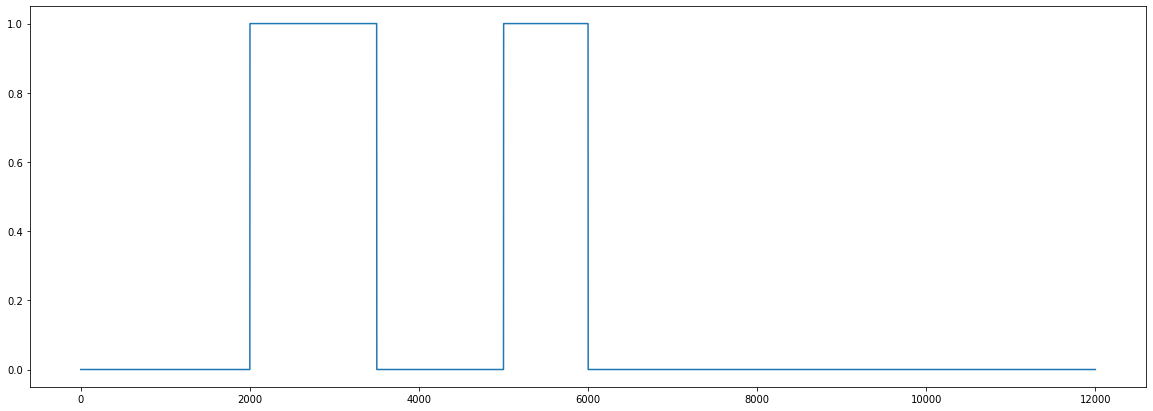

In [64]:
#Exercise 4.
#Task 1.
#Subtask a)

#1. Generate a signal
true_edges = [2000, 3500, 5000, 6000]
signal = np.zeros(12000)
signal[true_edges[0]:true_edges[1]] = 1.0
signal[true_edges[2]:true_edges[3]] = 1.0
plt.figure(figsize=(20,7))
plt.plot(signal)

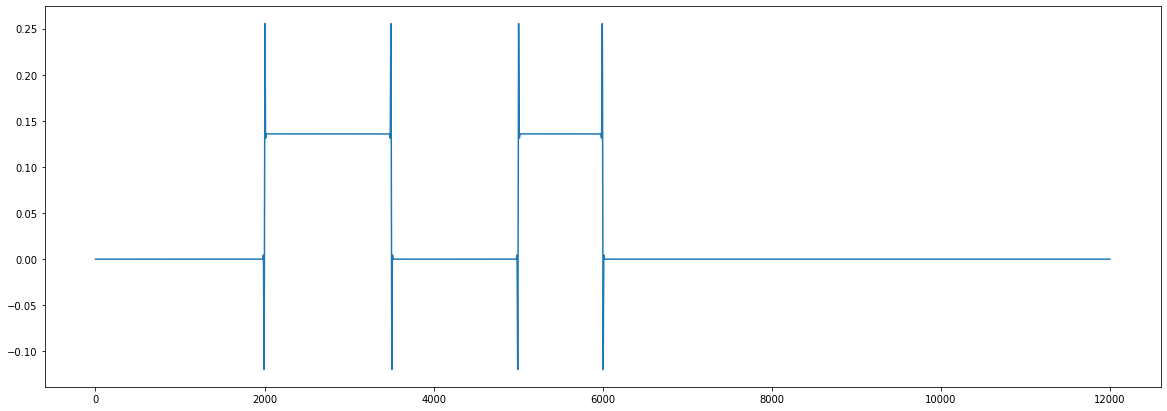

In [75]:
#2. Apply gaussian filter

def nth_gradient(X, n = 0):
    """
    N-th numerical differention
    """
    grad = X
    if n > 0:
        for i in range(n):
            dx = np.abs(X[1] - X[0])
            grad = np.gradient(X, dx)
    return grad

def get_kernel(sz, mu=0.0, sigma=0.05, sum_one=False, derivative = 0):
    """
    Differentable kernel θ  with integral == 1
    """
    #2.1 Construct kernel
    kernel = np.linspace(-1,1,sz)
    kernel = np.exp(-(((kernel-mu)**2.0)/(2.0*sigma**2)))
    
    if derivative >= 1:
        kernel = nth_gradient(kernel, derivative)
    
    #2.2 If integral == 1 is required
    if sum_one:
        kernel = kernel/sum(kernel)
        
    return kernel
        
def gaussian_smoothening(signal, mu=0.0, sigma=0.05, sum_one=False, derivative = 0):
    """
    Guassian smoothing function
    """
    #2.1 FFT
    signal_transformed = np.fft.fft(signal)
    signal_amplitude = np.abs(signal_transformed),
    signal_angle = np.angle(signal_transformed)
    signal_phase = np.exp(1j*signal_angle)
    signal_amplitude = np.fft.fftshift(signal_amplitude)

    #2.2 Construct kernel
    kernel = get_kernel(len(signal), mu=mu, sigma=sigma, sum_one=sum_one, derivative = derivative)

    #2.3 Apply kernel and reconstruct signal
    signal_amplitude = (kernel*signal_amplitude)[0]
    signal_amplitude = np.fft.ifftshift(signal_amplitude)
    signal_filtered = np.real(np.fft.ifft(signal_amplitude*signal_phase))
    return signal_filtered
signal_filtered = gaussian_smoothening(signal, 0.1, 0.05, False, 0)
plt.figure(figsize=(20,7))
plt.plot(signal_filtered)

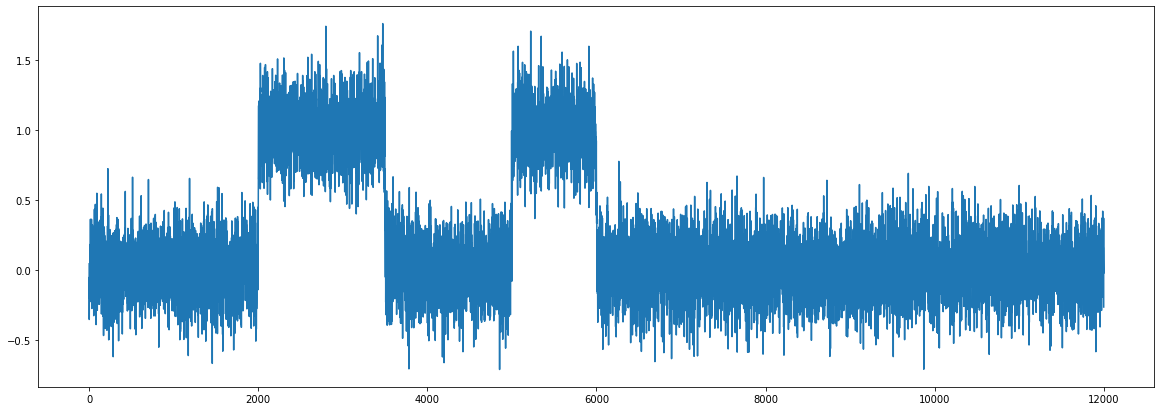

In [66]:
#3. Add noise
noise = np.random.normal(0.0,0.2,len(signal_filtered))
signal_filtered_noisy = signal_filtered+noise
plt.figure(figsize=(20,7))
plt.plot(signal_filtered_noisy)

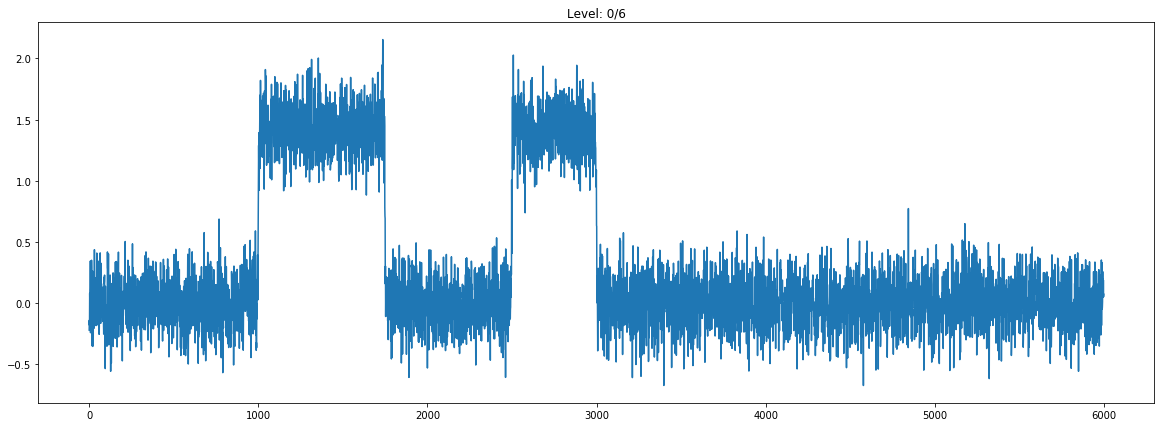

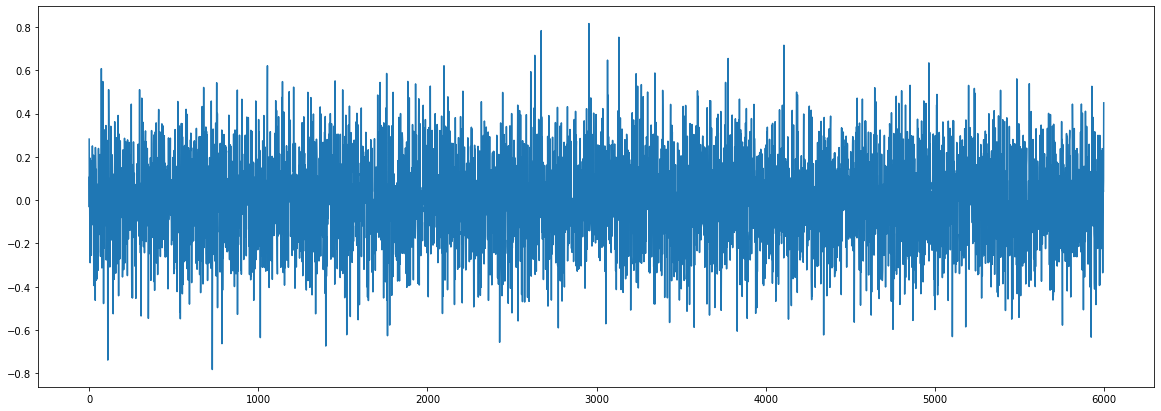

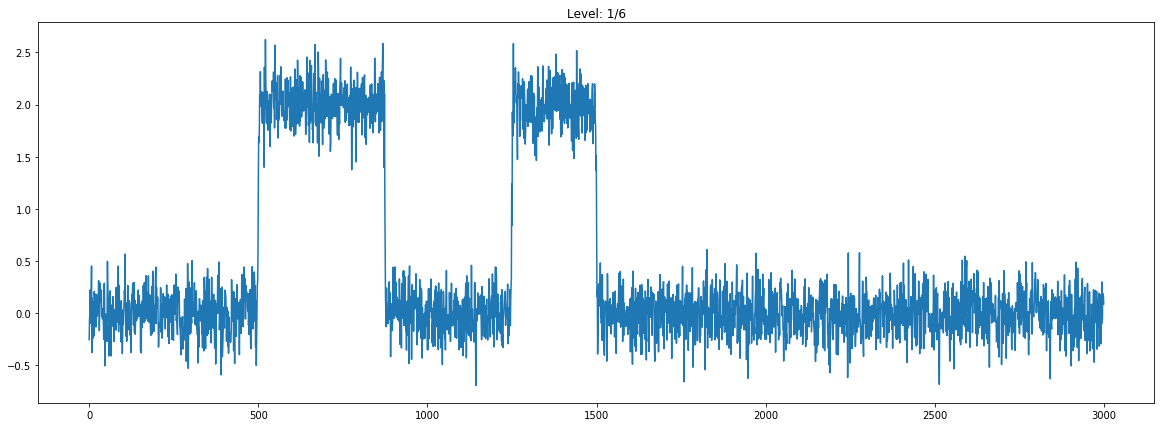

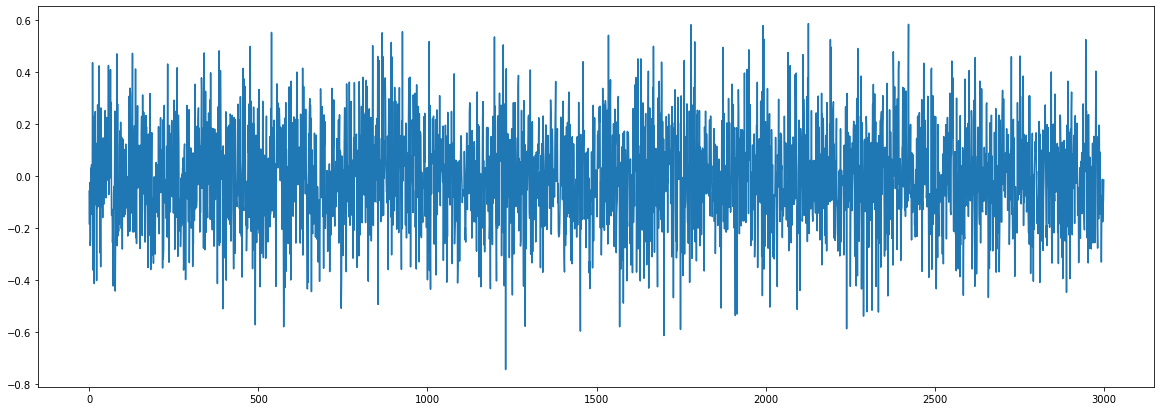

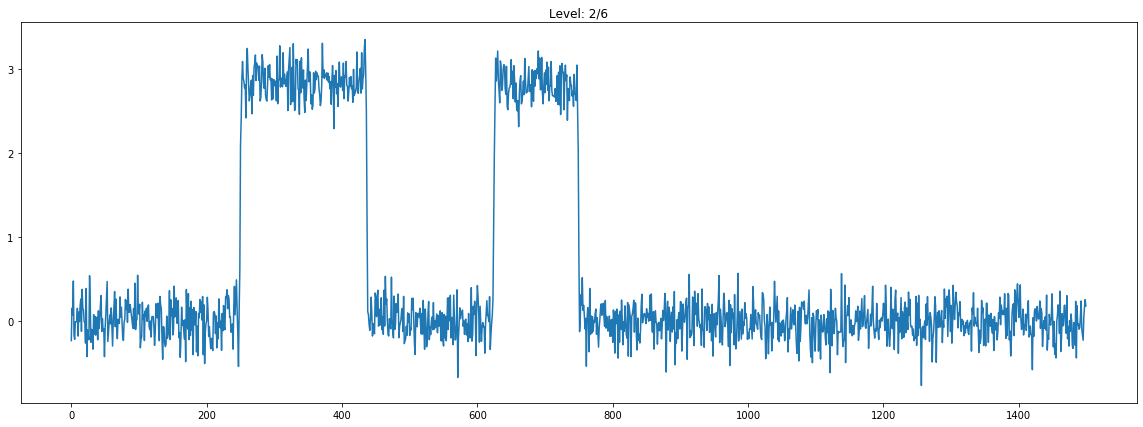

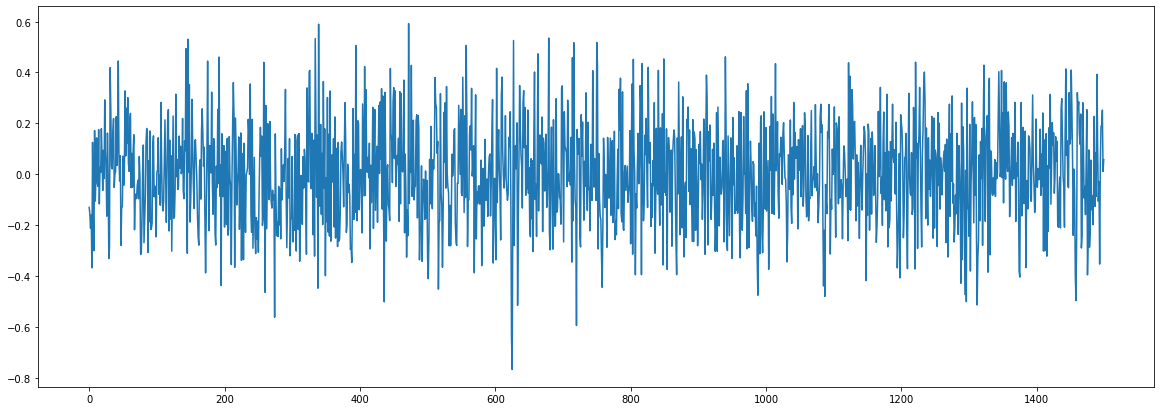

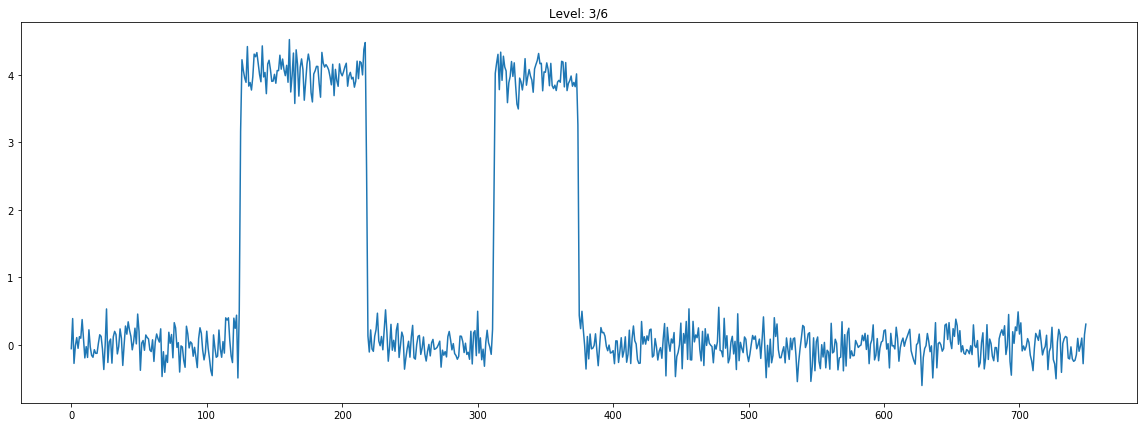

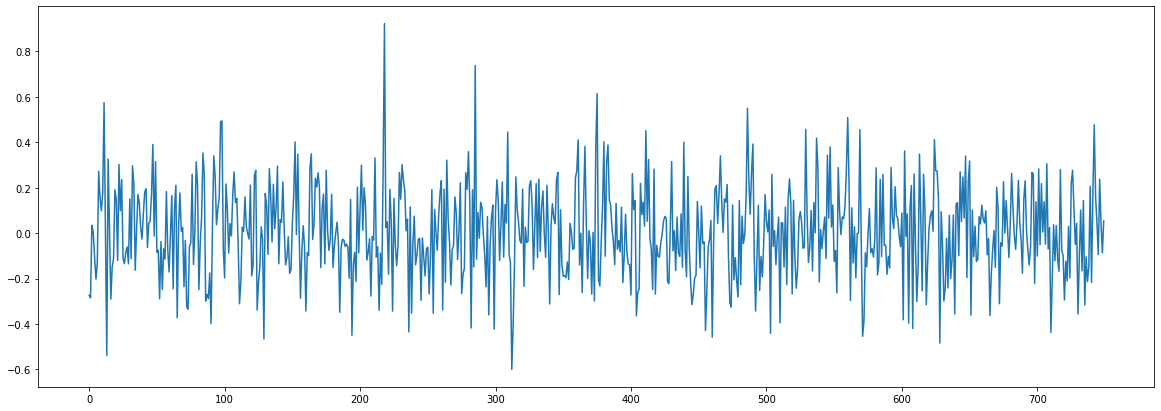

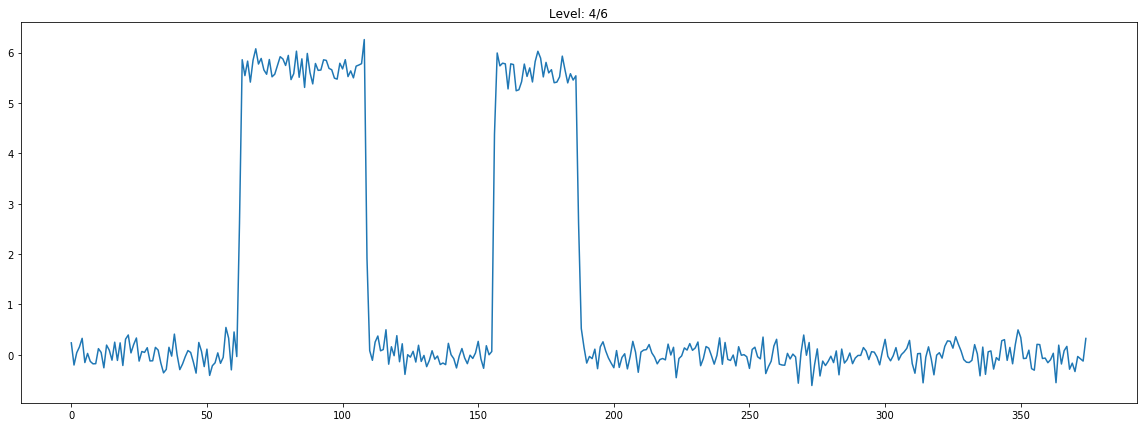

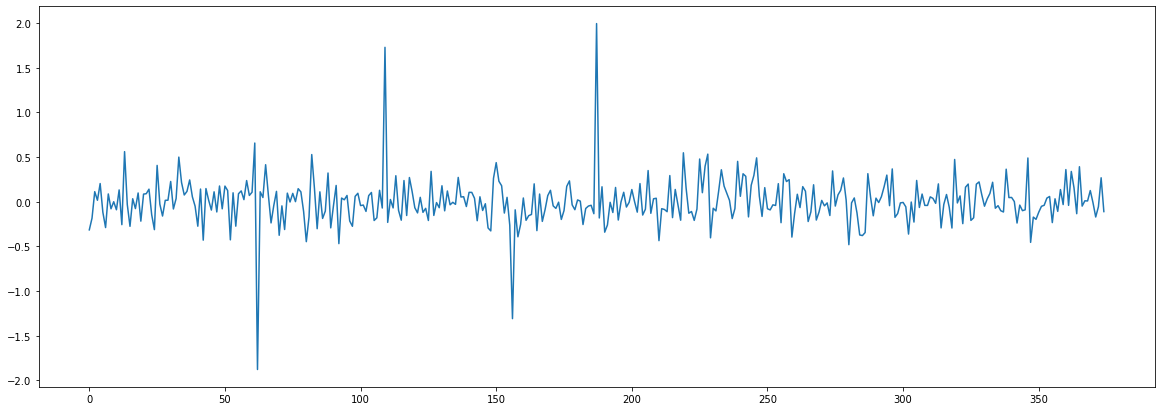

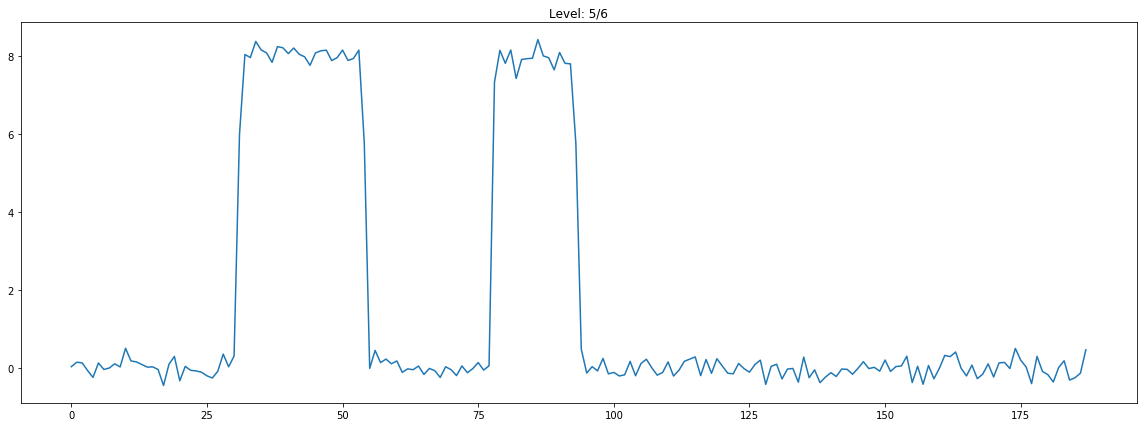

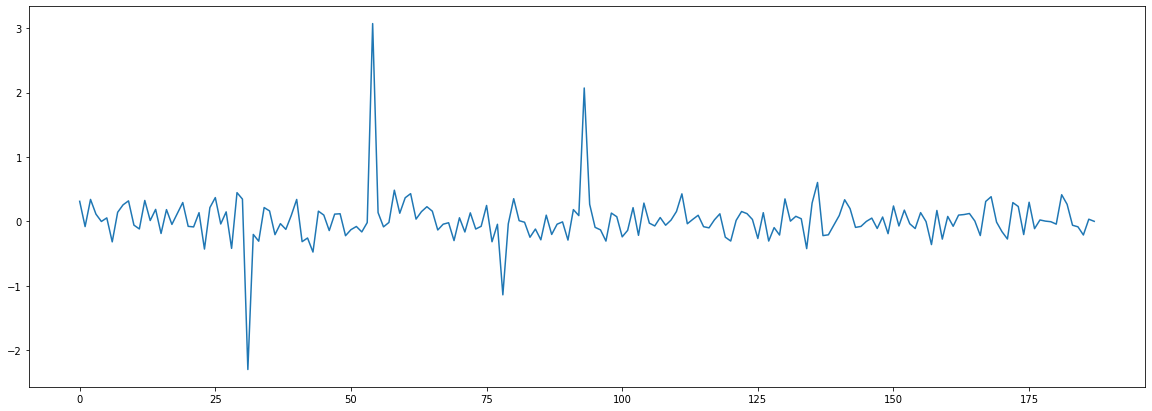

In [67]:
# Subtask b)
level = 6
mode = 'haar'

#Source: 
#https://github.com/PyWavelets/pywt/releases
#pywt/_multilevel.py wavedec
cA_list = [] #rename = []
cD_list = []
cA = signal_filtered_noisy
for i in range(level):
    cA, cD = pywt.dwt(cA, mode) #rename a,d
    cD_list.append(cD)
    cA_list.append(cA)

for i in range(level):
    plt.figure(figsize=(20,7))
    plt.plot(cA_list[i])
    plt.title("Level: {0}/{1}".format(i,level))
    plt.figure(figsize=(20,7))
    plt.plot(cD_list[i])
    plt.show()
    
#The noise is reduced with increasing levels, visually closest result to original signal at level 3 or 4.

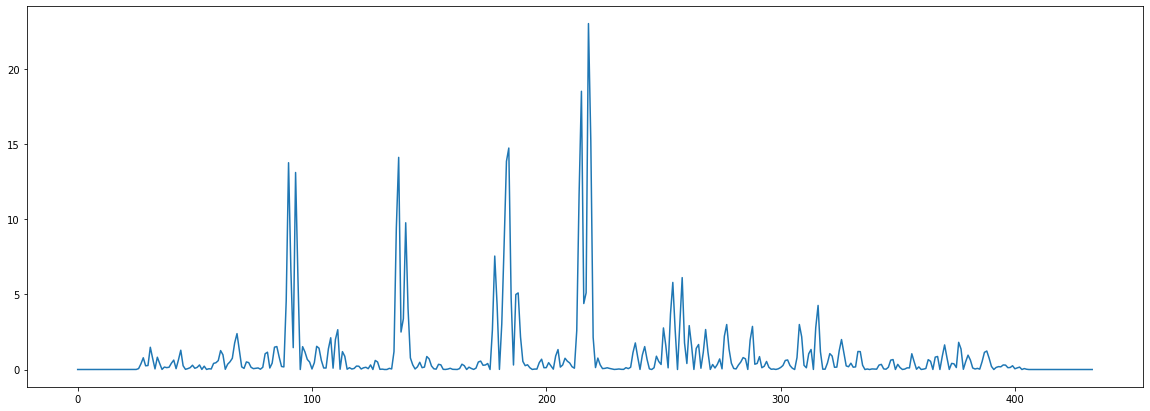

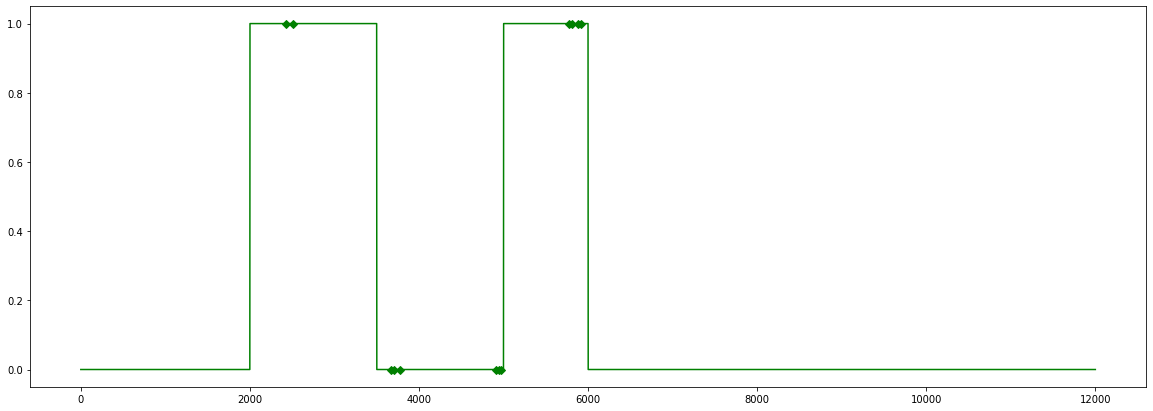

In [73]:
#Subtask c) 
def normalize(X):
    """
    Normalization without centering as defined by paper
    """
    return X/X.std()
        
def scale_product(X, scale, mu, sigma, kernel_sz):
    """
    Scale product P as defined in paper
    """
    kernel = get_kernel(kernel_sz, mu, sigma, True, 0)
    w_j = nth_gradient(np.convolve(X, kernel), scale)
    w_jpp = nth_gradient(np.convolve(X, kernel), scale+1)
    return np.abs(normalize((w_j*2**scale))*normalize((w_jpp*2**(scale+1))))


def get_threshold(mu, sigma, sum_one, scale, kernel_sz):
    """
    Calculate threshold t as defined in paper
    """
    psi_j=get_kernel(kernel_sz, mu, sigma, sum_one, scale)
    psi_jpp=get_kernel(kernel_sz, mu, sigma, sum_one, scale+1)
    sigma_j = sigma*np.linalg.norm(psi_j)
    sigma_jpp = 0.5*np.sqrt(np.linalg.norm(psi_j/np.linalg.norm(psi_j)+psi_jpp/np.linalg.norm(psi_jpp)))
    return (4.0*sigma_jpp)**2

def simple_score(predicted_edges, true_edges, signal, sigma):
    """
    Simple sliding window euclidean scorer for hyper param optimization, lower is better.
    This is my own idea, works somwhat okay-ish.
    Basically i am taking the euclidean distance of the sum of the predicted edges and the true edges
    and then weight this by the difference of the number of found edges and true edges
    and the difference in the indices of the predicted and true edges.
    """
    score = 0
    true_edges = np.array(true_edges)
    for i in range(len(predicted_edges)-len(true_edges)):
        window = np.array(predicted_edges[i:i+len(true_edges)])
        score += np.linalg.norm(window-true_edges)*np.linalg.norm(signal[window]-signal[true_edges])*i
    score = score*np.abs(len(true_edges)-(len(predicted_edges)))
    return score
    
        
#First test of Algorithm with fixed hyper parameters
coeffictients=4
scale=60
sigma = 0.05
mu = 0.0

X_0 = cD_list[coeffictients]
Y_0 = scale_product(X_0, scale, mu, sigma, scale)
t = get_threshold(mu, sigma, True, scale, scale)

upscale_factor = int(len(signal)/len(Y_0))
predicted_edges = list([int(upscale_factor*x) for x in (np.where(Y_0>t)[0])])
plt.figure(figsize=(20,7))
plt.plot(Y_0)
plt.show()

plt.figure(figsize=(20,7))
plt.plot(signal, '-gD', markevery=predicted_edges)
plt.show()

In [ ]:
#Simple grid search for hyper params
#Calculation may take a while, up to a minute on my laptop
#Can cause runtime warnings
best_score, best_scale, best_coefficients, best_predicted_edges = float('inf'), -1, -1, None
best_mu, best_sigma = 0.0, 0.05
sigmas = [0.02, 0.03, 0.04, 0.05, 0.1, 0.15]
mus = [0.0, 0.05, 0.1, 0.15, 0.2, 0.3]
for coefficients in range(0, len(cD_list)):
    for scale in range(4,80,5):
        for mu in mus:
            for sigma in sigmas:
                X_0 = cD_list[coefficients]
                Y_0 = scale_product(X_0, scale, mu, True, scale)
                t = get_threshold(mu, sigma, True, scale, scale)
                upscale_factor = int(len(signal)/len(Y_0))
                predicted_edges = list([int(upscale_factor*x) for x in (np.where(Y_0>t)[0])])
                score = simple_score(predicted_edges, true_edges, signal, sigma)
                if 0 < score < best_score:
                    best_score, best_scale, best_coefficients = score, scale, coefficients
                    best_mu, best_sigma = mu, sigma
                    best_predicted_edges = predicted_edges
            

print("Best params: score: {0}, scale: {1}, coefficients: {2}, mu: {3}, sigma: {4}".format(
    best_score, best_scale, best_coefficients, best_mu, best_sigma))
plt.figure(figsize=(20,7))
plt.plot(signal, '-gD', markevery=best_predicted_edges)
plt.show()

/home/lorenz/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
/home/lorenz/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars


In [ ]:
#Task 2.